In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu' )

In [21]:
device, torch.__version__

(device(type='cpu'), '1.13.0+cpu')

In [3]:
# train = True --> default 
train_dataset =  torchvision.datasets.FashionMNIST(
    './fashionMnist/data', download=True,transform=transforms.Compose([ transforms.ToTensor() ])
    ,train = True
)

test_dataset =  torchvision.datasets.FashionMNIST(
    './fashionMnist/data', download=True,transform=transforms.Compose([ transforms.ToTensor() ])
    , train = False
)

In [4]:
# 데이터 셋으로부터 데이터 로드하기
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [5]:
for i in train_loader:
    a, b = i
    print(a.shape,len(b))
    break

torch.Size([100, 1, 28, 28]) 100


In [6]:
# 600번 순환
len(train_loader)

600

In [7]:
# train data total = 100*600 = 60000

In [8]:
len(test_loader)

100

In [9]:
# test data total = 100*100 = 10000

In [10]:
temp1 = ['T-shirt/top'
,'Trouser'
,'Pullover'
,'Dress'
,'Coat'
,'Sandal'
,'Shirt'
,'Sneaker'
,'Bag'
,'Ankle boot'
]
temp2 = list(range(len(temp1)))
labelMap = dict(zip(temp2,temp1))

In [11]:
labelMap

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [12]:
len(train_dataset), np.random.randint(len(train_dataset))

(60000, 30063)

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

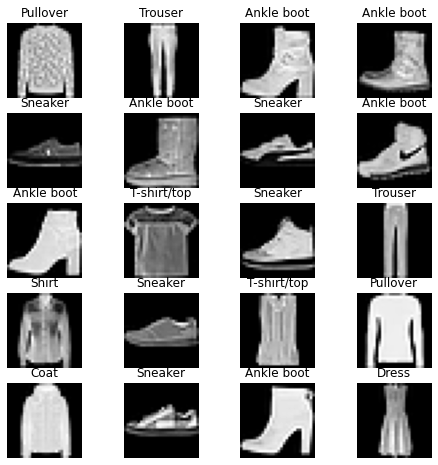

In [14]:
# 이미지 시각화
# ([0, 1, 28, 28],0)
fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 5
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]    # torch.Size([28, 28])
    fig.add_subplot(rows,columns,i)
    plt.title(labelMap[ train_dataset[img_xy][1] ])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()    

In [15]:
# ConvNet 미적용 신경망 설계
# F.relu() : forward에서 정의
# nn.Relu() : __init___에서 정의
class FashionDNN(nn.Module):
    def __init__(self):  # nn.OOO 는 init에서 설정  ㄹ
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features=256)  # 입력층
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)  # hidden layer 1
        self.fc3 = nn.Linear(in_features=128,out_features=10)  # 출력층
        
    # override 된 함수로 반드시 forward 라고 해야 하며
    # FashionDNN 객체를  데이터와 함께 호출하면 forward 가 자동으로 실행  callback함수임
    def forward(self, input_data):  # 전방계산을 위한 연결  순전파학습
        # 최초 입력을 설계한 입력 shape에 맞게 resize
        out = input_data.view(-1,784)  # reshape와 동일
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out        
        
        

In [16]:
# 모델 객체
lr = 1e-3  # 0.001
model = FashionDNN()
model.to(device)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
# 손실함수 옵티마이져 
criterion = nn.CrossEntropyLoss()  #분류문제에서 사용
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# 학습하기 위한 하이퍼 파라메터
num_epochs = 5
count = 0
loss_list, iteration_list,accuracy_list, prediction_list, labels_list = [],[],[],[],[]

In [24]:
# 학습
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 모델이 데이터를 처리하기 위해 동일한 장치에 있어야 함
        # 자동미분
        # Autograd : 자동미분의 값을 저장하기위해서 tape를 사용
        # 순전파, 역전파
        train = Variable(images.view(100,1,28,28)) # 사이즈 조정(이미 되어 있어서 안해도 되지만... 일관성을 위해서)
        
        labels = Variable(labels)
        outputs = model(train)  # 학습데이터 모델에 적용
        loss = criterion(outputs,labels)
        optimizer.zero_grad() # 기울기는 가중치와 달라서 업데이트 되면 안됨 그래서 매번 초기화 함
        loss.backward() # 오차를 각 가중치에 업데이트하는데. 기여한 만큼 한다.( 오차에 가중치미분값을 곱해서 나온값을 각 가중치에 빼준다)
        optimizer.step() # 옵티마이져를 업데이트(zero)
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct*100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
        

Iteration : 500, Loss : 0.5197024941444397, Accuracy : 84.08999633789062
Iteration : 1000, Loss : 0.4137642979621887, Accuracy : 84.58999633789062
Iteration : 1500, Loss : 0.3613997995853424, Accuracy : 84.51000213623047
Iteration : 2000, Loss : 0.43334415555000305, Accuracy : 85.61000061035156
Iteration : 2500, Loss : 0.2584071457386017, Accuracy : 85.9800033569336
Iteration : 3000, Loss : 0.2810910940170288, Accuracy : 85.76000213623047


In [25]:
# 정확도를 가지고 측정할때는 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지 모른다...
# 데이터의 특성에 따른 정확도를 잘 관측해야 함.

In [62]:
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[str, int, Tuple[int, int]] = 0, dilation: Union[int, Tuple[int, int]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device=None, dtype=None) -> None
 |  
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |  
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N

# 합성곱 신경망

In [73]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1) # [32,784,784]
            ,nn.BatchNorm2d(32)  # 학습과정에서 각 배치단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화
            ,nn.LeakyReLU()
            ,nn.MaxPool2d(2,stride=2) # 32, 14, 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)  # [64,12,12]
            ,nn.BatchNorm2d(64)  # 학습과정에서 각 배치단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화
            ,nn.LeakyReLU()
            ,nn.MaxPool2d(2)  # 64, 6, 6
        )
        # Conv2d 에서 출력 크기 구하는 공식
        # 이미지 형태의 데이터를 배열 형태로 변환작업  (W-F+2P)/S+1
        # W : 입력데이터의 크기
        # F:커널 크기
        # P:패딩크기
        # S:스트라이드
        # (784-3+(2*0))/1+1 = 784  -> [32,784,784]
        
        # MaxPool2d에서 출력 크기 구하는 공식
        # IF/F
        # IF : 입력필터의 크기 또는 바로 앞의 Conv2d의 출력크기
        # F : 커널 크기
        # 784 / 2 = 392
        #[32,392,392]       
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop(out)        
        out = self.fc2(out)
        out = self.fc3(out)
        return out        

In [74]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [76]:
# 학습
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 모델이 데이터를 처리하기 위해 동일한 장치에 있어야 함
        # 자동미분
        # Autograd : 자동미분의 값을 저장하기위해서 tape를 사용
        # 순전파, 역전파
        train = Variable(images.view(100,1,28,28)) # 사이즈 조정(이미 되어 있어서 안해도 되지만... 일관성을 위해서)
        # print(f"train : {train.shape}")
        labels = Variable(labels)
        outputs = model(train)  # 학습데이터 모델에 적용
        loss = criterion(outputs,labels)
        optimizer.zero_grad() # 기울기는 가중치와 달라서 업데이트 되면 안됨 그래서 매번 초기화 함
        loss.backward() # 오차를 각 가중치에 업데이트하는데. 기여한 만큼 한다.( 오차에 가중치미분값을 곱해서 나온값을 각 가중치에 빼준다)
        optimizer.step() # 옵티마이져를 업데이트(zero)
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct*100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")

Iteration : 500, Loss : 0.6619741916656494, Accuracy : 84.41000366210938
Iteration : 1000, Loss : 0.33753785490989685, Accuracy : 87.16000366210938
Iteration : 1500, Loss : 0.1871587634086609, Accuracy : 89.52999877929688
Iteration : 2000, Loss : 0.30572301149368286, Accuracy : 89.04000091552734
Iteration : 2500, Loss : 0.18123431503772736, Accuracy : 90.88999938964844
Iteration : 3000, Loss : 0.19210705161094666, Accuracy : 88.91999816894531


In [ ]:
# 전이학습
# 이미지넷 : 이미지로 이루어진 데이터셋 :  --> 이런 이미지넷을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용
# 아주 큰 데이터셋을 사용해서 훈련된 모델을 사전훈련된 모델(네트웍)이라고 함

In [77]:
# 특성추출기법
# ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전 연결층 부분만 새로 만듦
# 특성 추출은 두 부분으로 구성
# 합성곱층 : 
# 데이터 분류기(완전연결층)
# 합성곱층(가중치 고정)에 새로운 데이터를 통과 -> 그 출력을 데이터 분류기에서 훈련시킴

In [78]:
'''
XCeption
Inception V3
ResNet50
VGG16
VGG19
MobileNet
'''

'\nXCeption\nInception V3\nResNet50\nVGG16\nVGG19\nMobileNet\n'

In [79]:
# 필요 라이브러리 설치
!pip install opencv-python

     --------------------------------------- 35.6/35.6 MB 28.5 MB/s eta 0:00:00


In [123]:
import os
import time
import copy
import glob
import cv2
import shutil
import torch
import torchvision # 컴퓨터 비전
import torchvision.transforms as transforms # 데이터 전처리
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [82]:
data_path = 'E:/7.ai/catanddog/train'

In [84]:
transform =  transforms.Compose(
    [
        transforms.Resize([256,256]),  # 크기조정
        transforms.RandomResizedCrop(224), # 이미지를 랜덤한 크기 및 비율로 자름,  데이터 확장용도로사용 즉.. 데이터를 랜덤한비율로 잘라서 크기를 조정
        transforms.RandomHorizontalFlip(), # 수평으로 뒤집음
        transforms.ToTensor() # 텐서로 변경
    ]
)
train_dataset = torchvision.datasets.ImageFolder(data_path,transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=6,
    shuffle=True
)
print(len(train_dataset))

385


In [85]:
# 개 고양이 데이터는 캐글에 있는데 여기서는 385개만 사용

In [86]:
# RandomResizedCrop 사용하기 위해서 mxnet을 설치
!pip install mxnet

  Using cached mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl (33.1 MB)
  Using cached requests-2.18.4-py2.py3-none-any.whl (88 kB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached numpy-1.16.6.zip (5.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached idna-2.6-py2.py3-none-any.whl (56 kB)
  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Created wheel for numpy: filename=numpy-1.16.6-cp39-cp39-win_amd64.whl size=3708117 sha256=e352d0a0c3d558318be36e0133d2f8df1dcc0c694234b1668ec3841d45a954cc
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ce\72\38\377a1055ac9b575ebba22e507856aecdc37f9bf6372703e5f9
Successfully built numpy
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.11
    Uninstalling urllib3-1.26.11:
      Successfully uninstalled urllib3-1.26.11
  Attempting uninstall: i

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\user\\miniconda3\\envs\\ml\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [87]:
!pip install --user mxnet

  Using cached mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl (33.1 MB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)


In [88]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

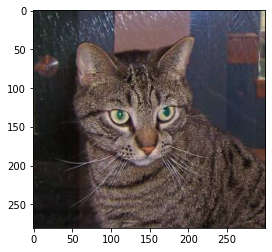

In [89]:
sample_image = mx.image.imread('E:/7.ai/catanddog/train/Cat/1.jpg')
plt.imshow(sample_image.asnumpy())

In [93]:
# RandomResizedCrop 적용 함수
def show_images(imgs, num_rows,num_cols,scale=2):
    aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1] # 확장할 이미지의 크기 조정
    figsize = (num_cols*scale, num_rows*scale*aspect_ratio)
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False) # x축 전체를 숨기
            axes[i][j].axes.get_yaxis().set_visible(False) # y축 전체를 숨기
    plt.subplots_adjust(hspace=0.1, wspace=0)
    return axes

In [98]:
import pandas as pd

In [101]:
def apply(img,aug,num_rows=2, num_cols=4, scale=3):
    Y = [ aug(img) for _ in range(num_rows * num_cols)]    
    show_images(Y,num_rows, num_cols,scale)

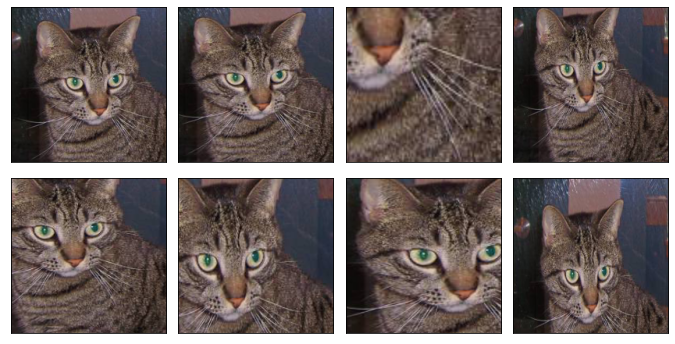

In [102]:
shape_aug = transforms.RandomResizedCrop(
    size=(200,200),  # 출력 비율을 200 x 200
    scale=(0.1,1),   # 면적비율을 0.1~1(10 ~ 100%) 범위내에서 무작위로 자름
    ratio=(0.5,2)    # 면적의 너비와 높이 비율을 0.5 ~ 2 범위 내에서 무작위로 조절
)
apply(sample_image,shape_aug)

In [118]:
# 학습에 사용할 데이터 확인 24개
temp = iter(train_loader)
samples,labels =  next(temp)

In [119]:
labels[0].item()

0

In [120]:
samples[0].numpy().shape, samples[0].numpy().T.shape

((3, 224, 224), (224, 224, 3))

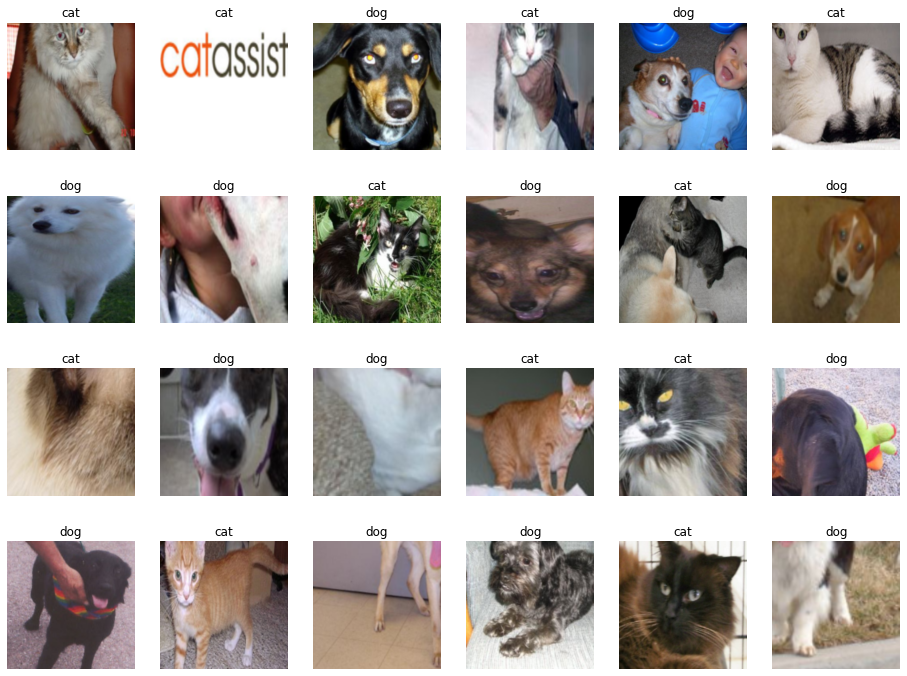

In [122]:
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(1,24+1):
    ax = fig.add_subplot(4,6,i)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    ax.imshow(np.transpose( samples[i].numpy(), (1,2,0) ))
plt.subplots_adjust(bottom=0.2, top=0.6,hspace=0)    

In [128]:
# 사전훈련된 모델 받기
resnet18 = models.resnet18(weights = True) # 사전에 학습된 가중치를 사용
# 50 개의 층으로 이루어진 함성곱 신경망
alexnet = models.alexnet(weights = True)
squeezenet1_0 = models.squeezenet1_0(weights = True)
vgg16 = models.vgg16(weights = True)
densenet161 = models.densenet161(weights = True)
inception_v3 = models.inception_v3(weights = True)
googlenet = models.googlenet(weights = True)
shufflenet_v2_x1_0 = models.shufflenet_v2_x1_0(weights = True)
mobilenet_v2 = models.mobilenet_v2 (weights = True)
mobilenet_v3_large = models.mobilenet_v3_large(weights = True)
mobilenet_v3_small = models.mobilenet_v3_small(weights = True)
resnext50_32x4d = models.resnext50_32x4d(weights = True)
wide_resnet50_2 = models.wide_resnet50_2(weights = True)
mnasnet1_0 = models.mnasnet1_0(weights = True)

C:\Users\user\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\user\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\user/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

C:\Users\user\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\user/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

C:\Users\user\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

C:\Users\user\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\user/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

KeyboardInterrupt: 